In [ ]:
# ============================================================================
# Import Libraries
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

In [ ]:
# ============================================================================
# Load and Explore Data
# ============================================================================
df = pd.read_csv("dataset/obesity.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nDescriptive statistics:")
print(df.describe())

Dataset shape: (2111, 17)

First 5 rows:
   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_

In [ ]:
# ============================================================================
# Define Variables
# ============================================================================
# Quantitative variables
quant_vars = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

# Qualitative variables
qual_vars = [
    "Gender",
    "family_history_with_overweight",
    "FAVC",
    "CAEC",
    "SMOKE",
    "CALC",
    "SCC",
    "MTRANS",
]

# Target variable
target = "NObeyesdad"

print(f"Quantitative variables: {quant_vars}")
print(f"Qualitative variables: {qual_vars}")
print(f"Target variable: {target}")
print(f"\nTarget distribution:")
print(df[target].value_counts().sort_index())

Quantitative variables: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Qualitative variables: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'CALC', 'SCC', 'MTRANS']
Target variable: NObeyesdad

Target distribution:
NObeyesdad
Insufficient_Weight    272
Normal_Weight          287
Obesity_Type_I         351
Obesity_Type_II        297
Obesity_Type_III       324
Overweight_Level_I     290
Overweight_Level_II    290
Name: count, dtype: int64


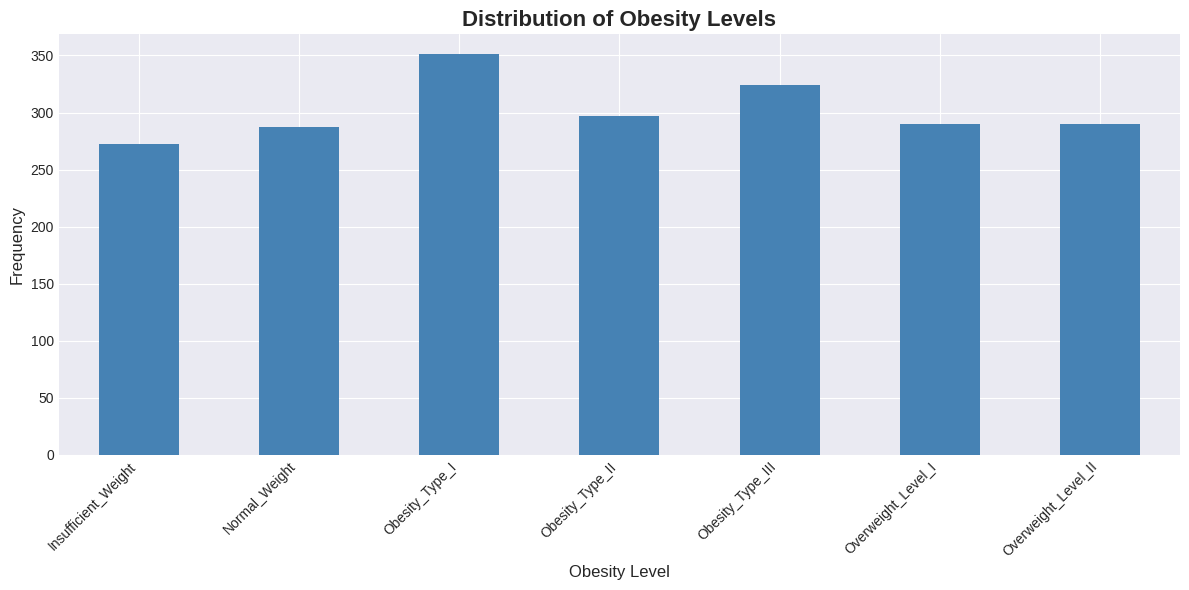

In [ ]:
# ============================================================================
# Visualize Target Distribution
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
df[target].value_counts().sort_index().plot(kind="bar", ax=ax, color="steelblue")
ax.set_title("Distribution of Obesity Levels", fontsize=16, fontweight="bold")
ax.set_xlabel("Obesity Level", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# MCA on Categorical Variables
# ============================================================================
df_qual = df[qual_vars].copy()

# Create dummy variables for categorical features
df_dummies = pd.get_dummies(df_qual, drop_first=False)
print(f"Indicator matrix shape: {df_dummies.shape}")

# Standardize
scaler_mca = StandardScaler()
X_mca_scaled = scaler_mca.fit_transform(df_dummies)

# Apply PCA on indicator matrix (this is MCA)
n_components_mca = 5
pca_mca = PCA(n_components=n_components_mca)
X_mca_transformed = pca_mca.fit_transform(X_mca_scaled)

print("\nVariance explained by each dimension:")
for i, var in enumerate(pca_mca.explained_variance_ratio_, 1):
    print(f"Dimension {i}: {var*100:.2f}%")
print(f"\nCumulative: {pca_mca.explained_variance_ratio_.sum()*100:.2f}%")

Indicator matrix shape: (2111, 23)

Variance explained by each dimension:
Dimension 1: 15.05%
Dimension 2: 10.54%
Dimension 3: 9.02%
Dimension 4: 8.26%
Dimension 5: 7.73%

Cumulative: 50.59%


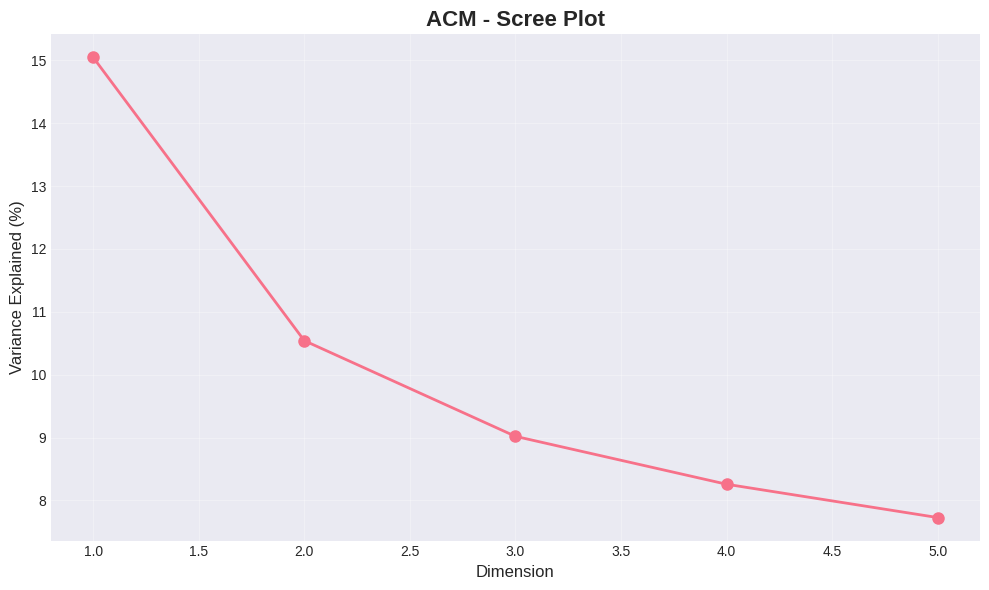

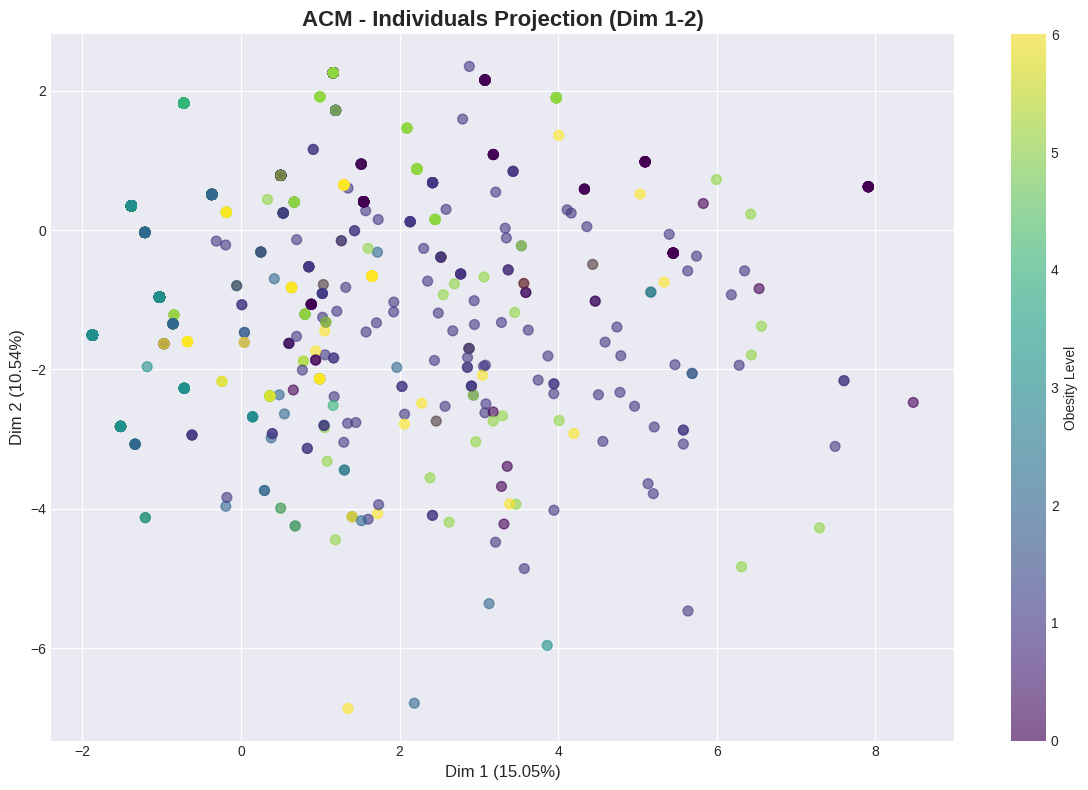

In [ ]:
# ============================================================================
# MCA Visualizations
# ============================================================================
# Scree plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, n_components_mca + 1),
    pca_mca.explained_variance_ratio_ * 100,
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=8,
)
ax.set_title("MCA - Scree Plot", fontsize=16, fontweight="bold")
ax.set_xlabel("Dimension", fontsize=12)
ax.set_ylabel("Variance Explained (%)", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Individuals projection
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(
    X_mca_transformed[:, 0],
    X_mca_transformed[:, 1],
    c=pd.Categorical(df[target]).codes,
    cmap="viridis",
    alpha=0.6,
    s=50,
)
ax.set_title("MCA - Individuals Projection (Dim 1-2)", fontsize=16, fontweight="bold")
ax.set_xlabel(f"Dim 1 ({pca_mca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
ax.set_ylabel(f"Dim 2 ({pca_mca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12)
plt.colorbar(scatter, label="Obesity Level", ax=ax)
plt.tight_layout()
plt.show()

Quantitative variables summary:
               Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866  
std       0.612953     0.850592     0.608927  
min       1.000000     0.000000     0.000000  
25%       1.584812     0.124505     0.000000  
50%       2.000000 

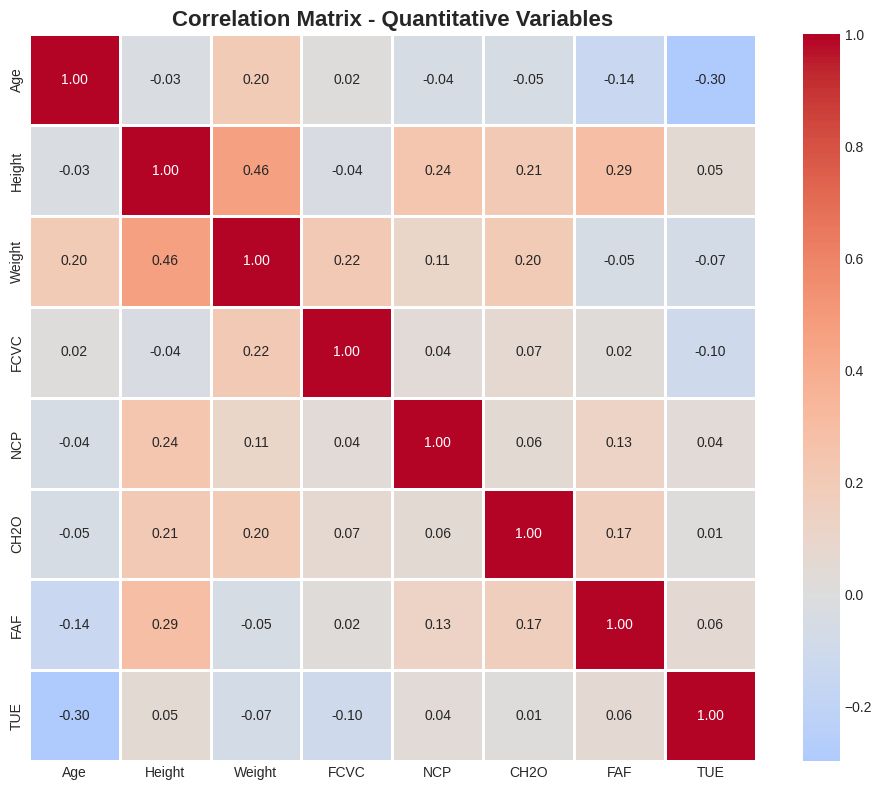

In [ ]:
# ============================================================================
# PCA on Quantitative Variables - Correlation Matrix
# ============================================================================
df_quant = df[quant_vars].copy()

print("Quantitative variables summary:")
print(df_quant.describe())

# Correlation matrix
corr_matrix = df_quant.corr()
print("\nCorrelation matrix:")
print(corr_matrix)

# Visualize correlation
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    ax=ax,
    square=True,
    linewidths=1,
)
ax.set_title(
    "Correlation Matrix - Quantitative Variables", fontsize=16, fontweight="bold"
)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# PCA on Quantitative Variables
# ============================================================================
# Standardize data
scaler_pca = StandardScaler()
X_quant_scaled = scaler_pca.fit_transform(df_quant)

# Apply PCA
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_quant_scaled)

print("Variance explained by each PC:")
for i, var in enumerate(pca_full.explained_variance_ratio_, 1):
    print(f"PC{i}: {var*100:.2f}%")

# Keep first 3 components
n_components_pca = 3
pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(X_quant_scaled)

print(
    f"\n{n_components_pca} PCs explain {pca.explained_variance_ratio_.sum()*100:.2f}% variance"
)

Variance explained by each PC:
PC1: 22.65%
PC2: 18.66%
PC3: 12.65%
PC4: 11.89%
PC5: 11.76%
PC6: 9.67%
PC7: 8.19%
PC8: 4.54%

3 PCs explain 53.95% variance


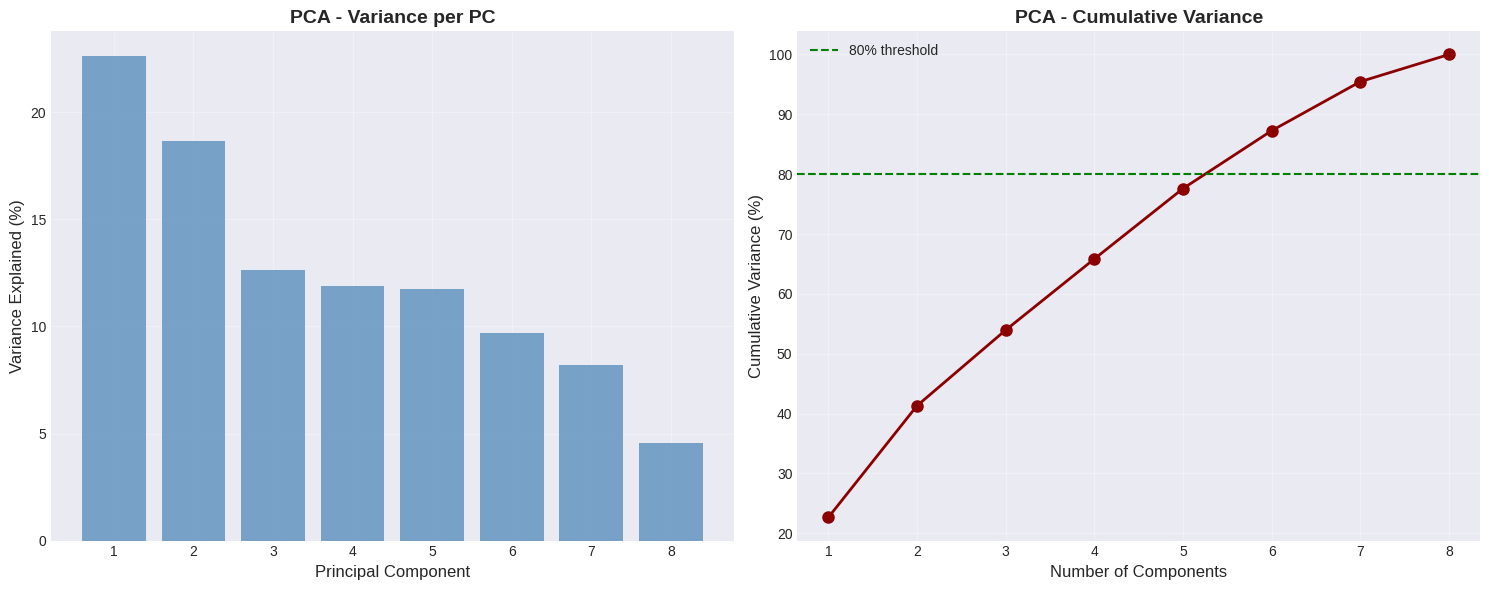

In [11]:
# ============================================================================
# PCA Scree Plot
# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Variance explained
ax1.bar(
    range(1, len(pca_full.explained_variance_ratio_) + 1),
    pca_full.explained_variance_ratio_ * 100,
    alpha=0.7,
    color="steelblue",
)
ax1.set_title("PCA - Variance per PC", fontsize=14, fontweight="bold")
ax1.set_xlabel("Principal Component", fontsize=12)
ax1.set_ylabel("Variance Explained (%)", fontsize=12)
ax1.grid(True, alpha=0.3)

# Cumulative variance
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
ax2.plot(
    range(1, len(cumsum_var) + 1),
    cumsum_var * 100,
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=8,
    color="darkred",
)
ax2.axhline(y=80, color="green", linestyle="--", label="80% threshold")
ax2.set_title("PCA - Cumulative Variance", fontsize=14, fontweight="bold")
ax2.set_xlabel("Number of Components", fontsize=12)
ax2.set_ylabel("Cumulative Variance (%)", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Variable contributions:
             PC1       PC2       PC3
Age     0.007592  0.603802 -0.338428
Height  0.598077 -0.070295 -0.298228
Weight  0.503661  0.361779 -0.011211
FCVC    0.161968  0.260187  0.830807
NCP     0.333123 -0.127778 -0.185856
CH2O    0.384655 -0.052993  0.260637
FAF     0.321236 -0.361647  0.040501
TUE     0.014639 -0.531014  0.045231


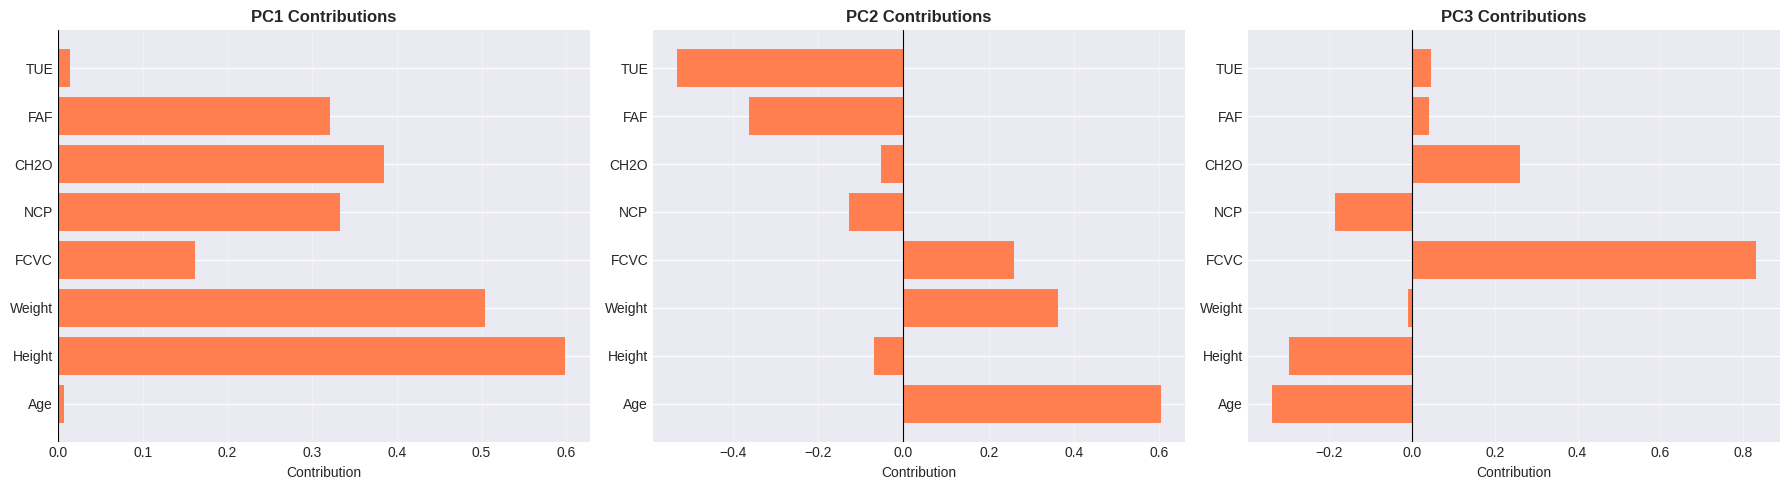

In [12]:
# ============================================================================
# PCA Variable Contributions
# ============================================================================
# Contributions to PCs
components_df = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(n_components_pca)],
    index=quant_vars,
)

print("Variable contributions:")
print(components_df)

# Visualize
fig, axes = plt.subplots(1, n_components_pca, figsize=(18, 5))
for i in range(n_components_pca):
    axes[i].barh(quant_vars, components_df[f"PC{i+1}"], color="coral")
    axes[i].set_title(f"PC{i+1} Contributions", fontweight="bold")
    axes[i].set_xlabel("Contribution", fontsize=10)
    axes[i].axvline(x=0, color="black", linewidth=0.8)
    axes[i].grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

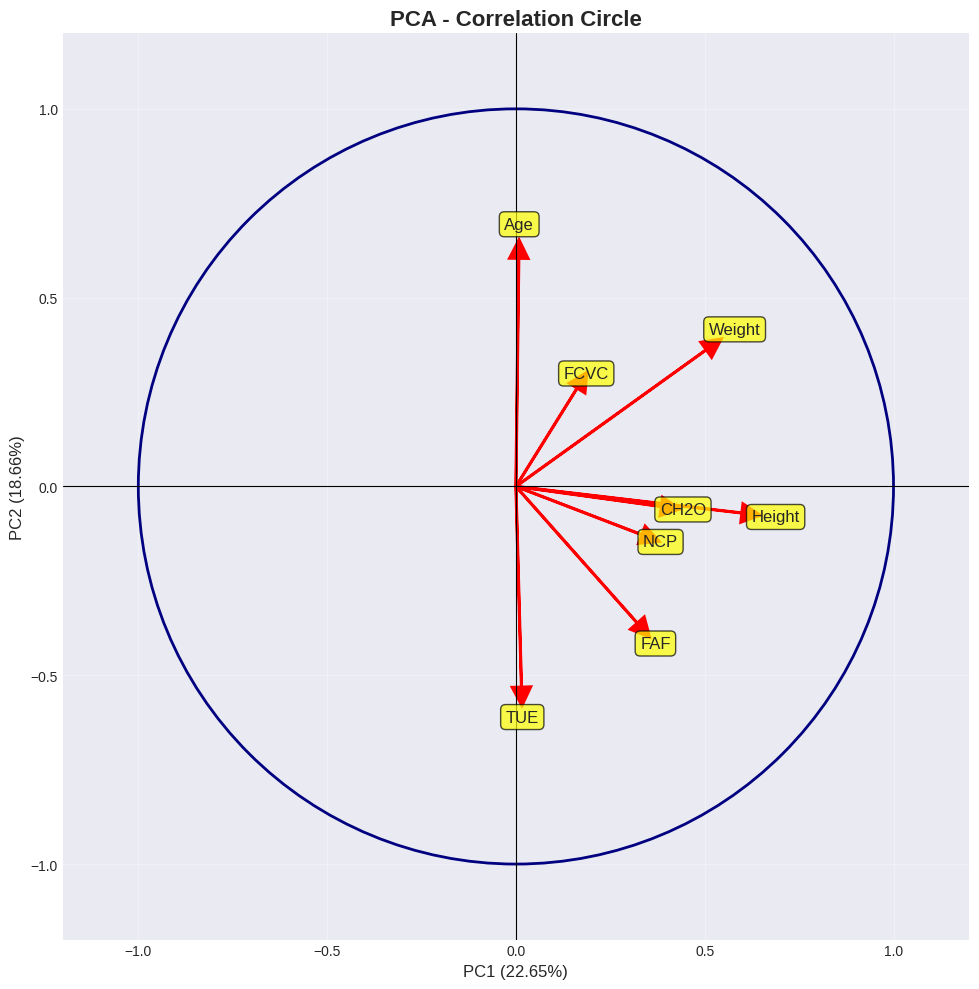

In [13]:
# ============================================================================
# PCA Correlation Circle
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 10))

# Draw circle
circle = plt.Circle((0, 0), 1, color="navy", fill=False, linewidth=2)
ax.add_patch(circle)

# Plot variable vectors
for i, var in enumerate(quant_vars):
    ax.arrow(
        0,
        0,
        components_df.loc[var, "PC1"],
        components_df.loc[var, "PC2"],
        head_width=0.05,
        head_length=0.05,
        fc="red",
        ec="red",
        linewidth=2,
    )
    ax.text(
        components_df.loc[var, "PC1"] * 1.15,
        components_df.loc[var, "PC2"] * 1.15,
        var,
        fontsize=12,
        ha="center",
        va="center",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
    )

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12)
ax.set_title("PCA - Correlation Circle", fontsize=16, fontweight="bold")
ax.axhline(y=0, color="black", linewidth=0.8)
ax.axvline(x=0, color="black", linewidth=0.8)
ax.grid(True, alpha=0.3)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

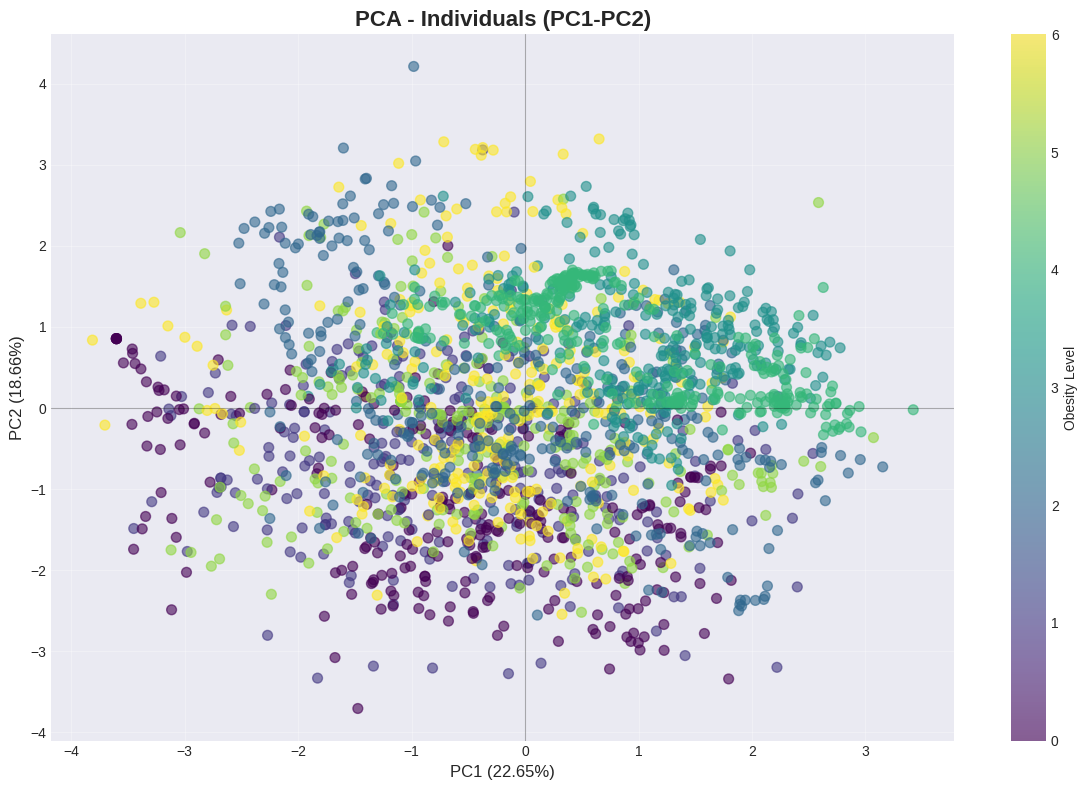

In [14]:
# ============================================================================
# PCA Individuals Projection
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=pd.Categorical(df[target]).codes,
    cmap="viridis",
    alpha=0.6,
    s=50,
)
ax.set_title("PCA - Individuals (PC1-PC2)", fontsize=16, fontweight="bold")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12)
ax.axhline(y=0, color="black", linewidth=0.8, alpha=0.3)
ax.axvline(x=0, color="black", linewidth=0.8, alpha=0.3)
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, label="Obesity Level", ax=ax)
plt.tight_layout()
plt.show()

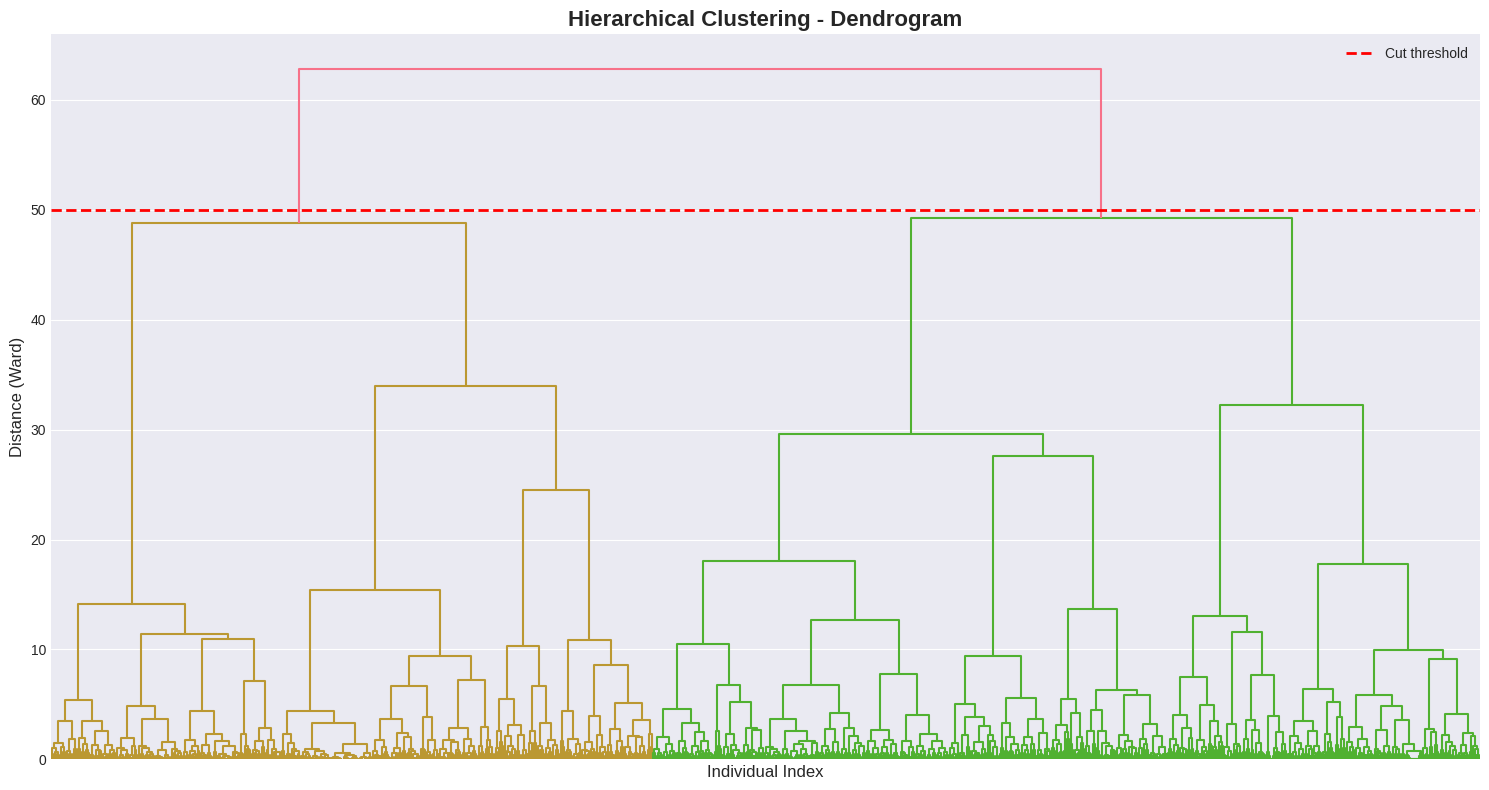

Cluster distribution:
Cluster 1: 340 (16.1%)
Cluster 2: 315 (14.9%)
Cluster 3: 234 (11.1%)
Cluster 4: 437 (20.7%)
Cluster 5: 324 (15.3%)
Cluster 6: 175 (8.3%)
Cluster 7: 286 (13.5%)


In [15]:
# ============================================================================
# Hierarchical Clustering
# ============================================================================
# Use PCA data for clustering
X_clustering = X_pca.copy()

# Perform hierarchical clustering (Ward method)
linkage_matrix = linkage(X_clustering, method="ward", metric="euclidean")

# Plot dendrogram
fig, ax = plt.subplots(figsize=(15, 8))
dendrogram(linkage_matrix, ax=ax, no_labels=True, color_threshold=50)
ax.set_title("Hierarchical Clustering - Dendrogram", fontsize=16, fontweight="bold")
ax.set_xlabel("Individual Index", fontsize=12)
ax.set_ylabel("Distance (Ward)", fontsize=12)
ax.axhline(y=50, color="red", linestyle="--", linewidth=2, label="Cut threshold")
ax.legend()
plt.tight_layout()
plt.show()

# Cut dendrogram to create 7 clusters
n_clusters_hier = 7
clusters_hier = fcluster(linkage_matrix, n_clusters_hier, criterion="maxclust")

print(f"Cluster distribution:")
unique, counts = np.unique(clusters_hier, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} ({count/len(clusters_hier)*100:.1f}%)")

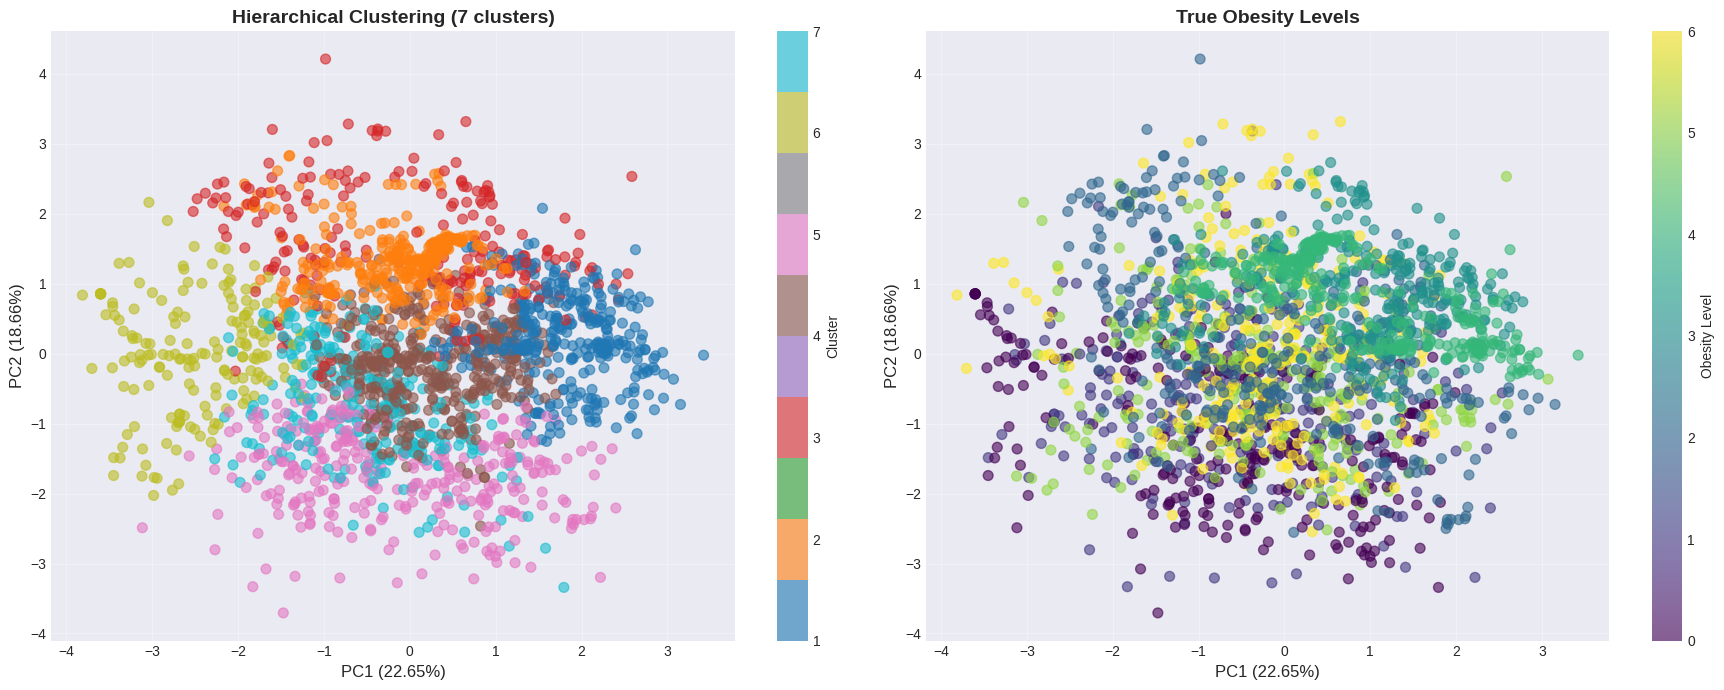

In [16]:
# ============================================================================
# Hierarchical Clustering Visualization
# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Hierarchical clusters
scatter1 = ax1.scatter(
    X_pca[:, 0], X_pca[:, 1], c=clusters_hier, cmap="tab10", alpha=0.6, s=50
)
ax1.set_title("Hierarchical Clustering (7 clusters)", fontsize=14, fontweight="bold")
ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12)
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label="Cluster")

# True obesity levels
scatter2 = ax2.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=pd.Categorical(df[target]).codes,
    cmap="viridis",
    alpha=0.6,
    s=50,
)
ax2.set_title("True Obesity Levels", fontsize=14, fontweight="bold")
ax2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
ax2.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12)
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label="Obesity Level")

plt.tight_layout()
plt.show()

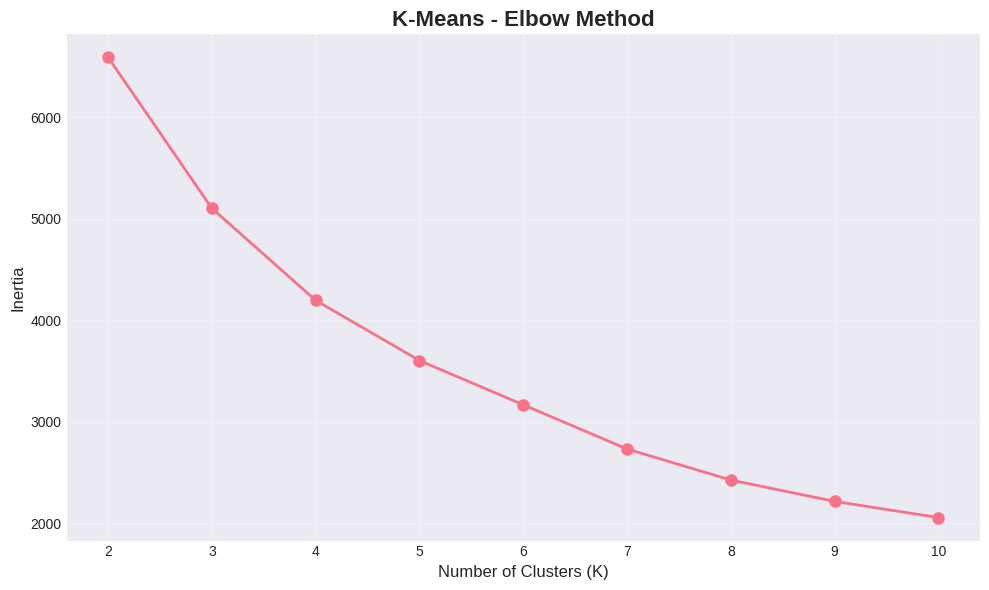

In [17]:
# ============================================================================
# K-Means Elbow Method
# ============================================================================
# Find optimal K using Elbow method
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_clustering)
    inertias.append(kmeans_temp.inertia_)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(K_range, inertias, marker="o", linestyle="-", linewidth=2, markersize=8)
ax.set_title("K-Means - Elbow Method", fontsize=16, fontweight="bold")
ax.set_xlabel("Number of Clusters (K)", fontsize=12)
ax.set_ylabel("Inertia", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# ============================================================================
# K-Means Algorithm
# ============================================================================
# Apply K-means with 7 clusters
n_clusters_kmeans = 7
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_clustering)

print(f"K-means inertia: {kmeans.inertia_:.2f}")
print("\nCluster distribution:")
unique_km, counts_km = np.unique(clusters_kmeans, return_counts=True)
for cluster, count in zip(unique_km, counts_km):
    print(f"Cluster {cluster}: {count} ({count/len(clusters_kmeans)*100:.1f}%)")

K-means inertia: 2730.36

Cluster distribution:
Cluster 0: 310 (14.7%)
Cluster 1: 348 (16.5%)
Cluster 2: 321 (15.2%)
Cluster 3: 301 (14.3%)
Cluster 4: 175 (8.3%)
Cluster 5: 352 (16.7%)
Cluster 6: 304 (14.4%)


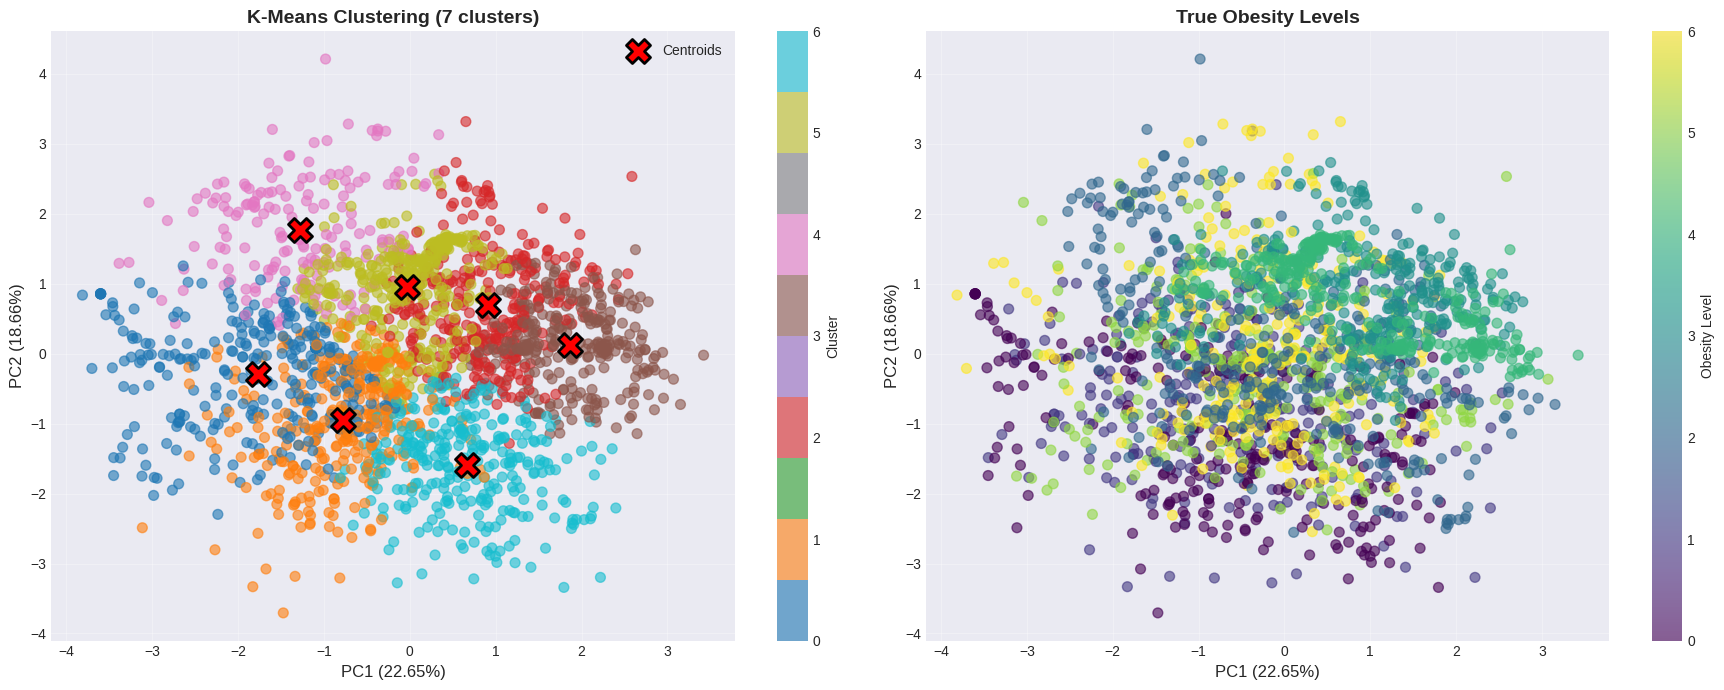

In [19]:
# ============================================================================
# K-Means Visualization
# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# K-means clusters
scatter1 = ax1.scatter(
    X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap="tab10", alpha=0.6, s=50
)
centers = kmeans.cluster_centers_
ax1.scatter(
    centers[:, 0],
    centers[:, 1],
    c="red",
    marker="X",
    s=300,
    edgecolors="black",
    linewidths=2,
    label="Centroids",
)
ax1.set_title("K-Means Clustering (7 clusters)", fontsize=14, fontweight="bold")
ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label="Cluster")

# True obesity levels
scatter2 = ax2.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=pd.Categorical(df[target]).codes,
    cmap="viridis",
    alpha=0.6,
    s=50,
)
ax2.set_title("True Obesity Levels", fontsize=14, fontweight="bold")
ax2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
ax2.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12)
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label="Obesity Level")

plt.tight_layout()
plt.show()

In [20]:
# ============================================================================
# LDA Preparation
# ============================================================================
# Use standardized quantitative variables
X_lda = X_quant_scaled.copy()
y_lda = df[target].copy()

# Encode target variable
le = LabelEncoder()
y_lda_encoded = le.fit_transform(y_lda)

print("Target classes:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_lda, y_lda_encoded, test_size=0.3, random_state=42, stratify=y_lda_encoded
)

print(f"\nTraining set: {len(X_train)}")
print(f"Test set: {len(X_test)}")

Target classes:
0: Insufficient_Weight
1: Normal_Weight
2: Obesity_Type_I
3: Obesity_Type_II
4: Obesity_Type_III
5: Overweight_Level_I
6: Overweight_Level_II

Training set: 1477
Test set: 634


In [21]:
# ============================================================================
# LDA
# ============================================================================
# Apply LDA
n_components_lda = min(len(quant_vars), len(le.classes_) - 1)
lda = LinearDiscriminantAnalysis(n_components=n_components_lda)
X_lda_transformed = lda.fit_transform(X_train, y_train)

print(f"Discriminant axes: {n_components_lda}")
print("\nVariance explained:")
explained_var_ratio = lda.explained_variance_ratio_
for i, var in enumerate(explained_var_ratio, 1):
    print(f"LD{i}: {var*100:.2f}%")
print(f"\nCumulative: {explained_var_ratio.sum()*100:.2f}%")

Discriminant axes: 6

Variance explained:
LD1: 96.56%
LD2: 2.67%
LD3: 0.55%
LD4: 0.13%
LD5: 0.05%
LD6: 0.04%

Cumulative: 100.00%


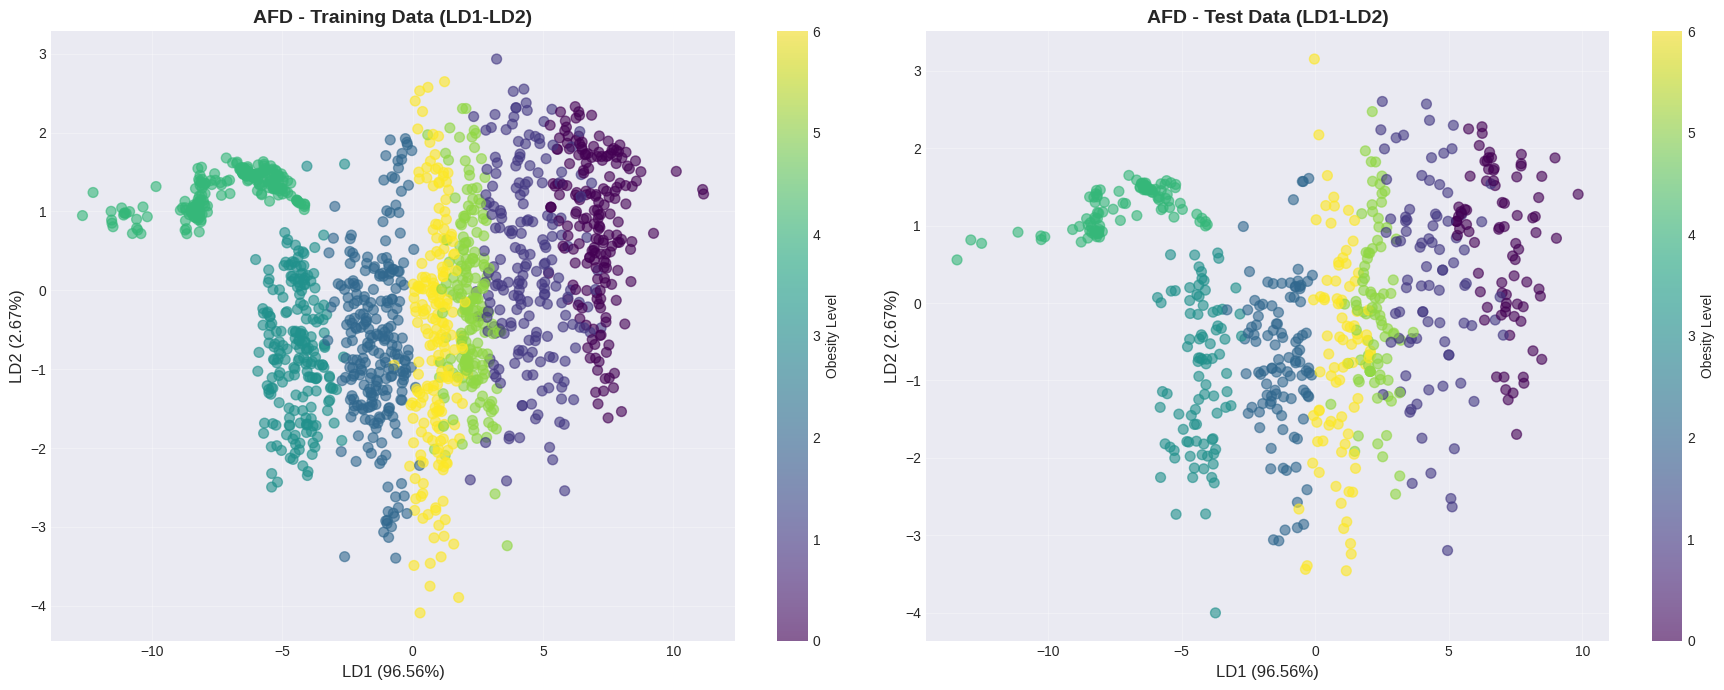

In [ ]:
# ============================================================================
# LDA Projection Visualization
# ============================================================================
X_test_lda = lda.transform(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Training data
scatter1 = ax1.scatter(
    X_lda_transformed[:, 0],
    X_lda_transformed[:, 1],
    c=y_train,
    cmap="viridis",
    alpha=0.6,
    s=50,
)
ax1.set_title("LDA - Training Data (LD1-LD2)", fontsize=14, fontweight="bold")
ax1.set_xlabel(f"LD1 ({explained_var_ratio[0]*100:.2f}%)", fontsize=12)
ax1.set_ylabel(f"LD2 ({explained_var_ratio[1]*100:.2f}%)", fontsize=12)
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label="Obesity Level")

# Test data
scatter2 = ax2.scatter(
    X_test_lda[:, 0], X_test_lda[:, 1], c=y_test, cmap="viridis", alpha=0.6, s=50
)
ax2.set_title("LDA - Test Data (LD1-LD2)", fontsize=14, fontweight="bold")
ax2.set_xlabel(f"LD1 ({explained_var_ratio[0]*100:.2f}%)", fontsize=12)
ax2.set_ylabel(f"LD2 ({explained_var_ratio[1]*100:.2f}%)", fontsize=12)
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label="Obesity Level")

plt.tight_layout()
plt.show()

In [23]:
# ============================================================================
# LDA Classification Performance
# ============================================================================
y_pred = lda.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy*100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

Overall Accuracy: 87.38%

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.87      0.89        82
      Normal_Weight       0.85      0.72      0.78        86
     Obesity_Type_I       0.99      0.96      0.98       106
    Obesity_Type_II       0.92      0.99      0.95        89
   Obesity_Type_III       0.99      0.93      0.96        97
 Overweight_Level_I       0.67      0.84      0.74        87
Overweight_Level_II       0.80      0.78      0.79        87

           accuracy                           0.87       634
          macro avg       0.88      0.87      0.87       634
       weighted avg       0.88      0.87      0.88       634



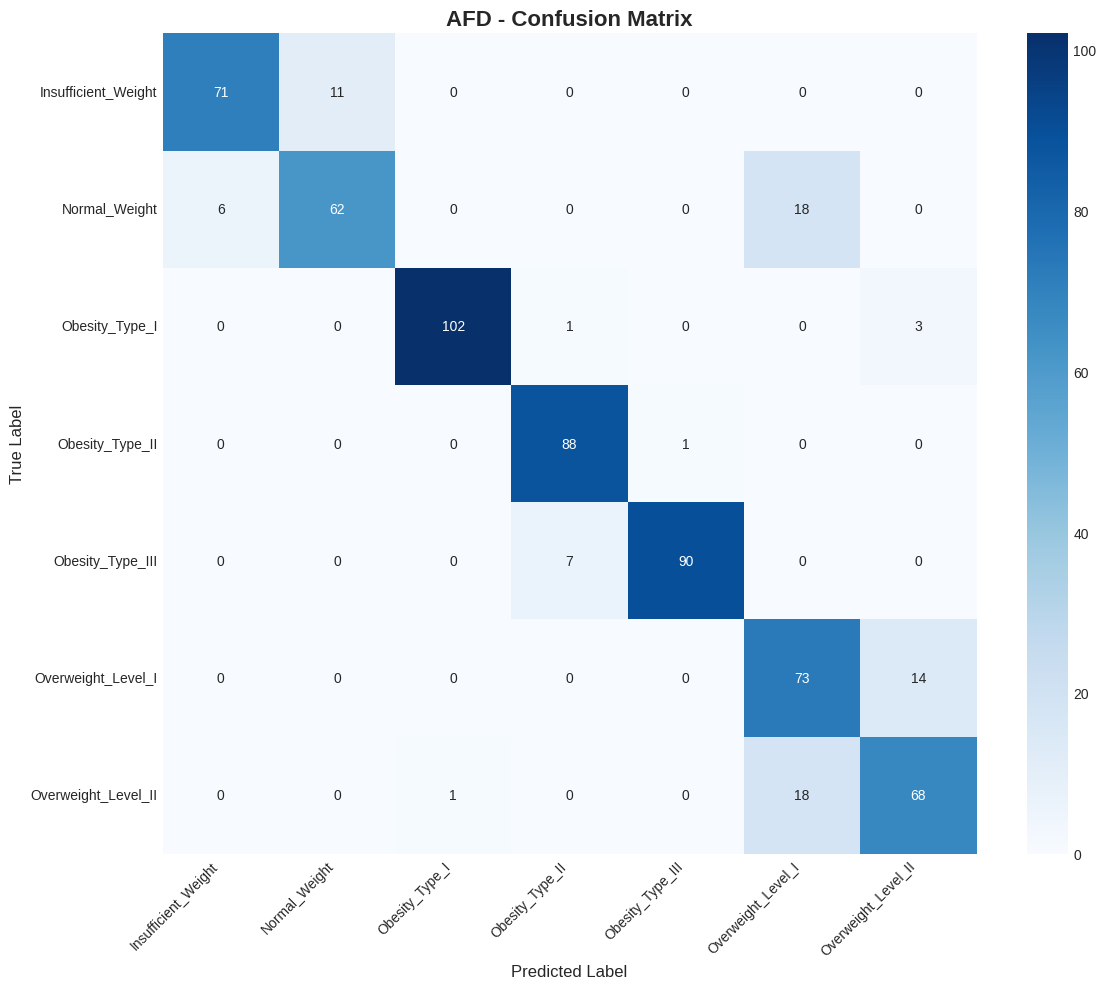

In [ ]:
# ============================================================================
# LDA Confusion Matrix
# ============================================================================
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax,
    xticklabels=le.classes_,
    yticklabels=le.classes_,
)
ax.set_title("LDA - Confusion Matrix", fontsize=16, fontweight="bold")
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# Summary
# ============================================================================
print("=" * 80)
print("ANALYSIS SUMMARY")
print("=" * 80)
print(
    f"""
1. MCA - {pca_mca.explained_variance_ratio_.sum()*100:.1f}% variance (5 dims)
2. PCA - {pca.explained_variance_ratio_.sum()*100:.1f}% variance (3 PCs)
3. Hierarchical Clustering - 7 clusters (Ward method)
4. K-Means - 7 clusters
5. LDA - {accuracy*100:.2f}% classification accuracy

Key Findings:
- Quantitative variables strongly correlate with obesity levels
- Weight, Height, Age are main PC1 contributors
- LDA provides best classification performance
- Clear separation between extreme obesity levels
"""
)

ANALYSIS SUMMARY

1. MCA - 50.6% variance (5 dims)
2. PCA - 54.0% variance (3 PCs)
3. Hierarchical Clustering - 7 clusters (Ward method)
4. K-Means - 7 clusters
5. LDA - 87.38% classification accuracy

Key Findings:
- Quantitative variables strongly correlate with obesity levels
- Weight, Height, Age are main PC1 contributors
- LDA provides best classification performance
- Clear separation between extreme obesity levels

